# Intro to Weather Data in TileDB

## About This Tutorial

This tutorial shows using some standard open-source geospatial tools with a TileDB dense array.

### What it Shows

1. Creating multiple dense arrays with a tiledb.cf DataspaceCreator
2. Reading/writing arrays with tiledb.cf Group
3. Using the TileDB xarray backend and rasterio to do analysis on polygon regions

### Set-up Requirements

This example requires the following Python libraries: tiledb, tiledb-cf, numpy, xarray, rasterio, cartopy, matplotlib, geopandas

In [1]:
import tiledb
import tiledb.cf

import geopandas as gpd
import numpy as np
import xarray as xr

import rasterio
import rasterio.features
import rasterio.transform

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

example_uri = "arrays/fake_weather_example"

In [2]:
import shutil

# clean up any previous runs
try:
    shutil.rmtree(example_uri)
except:
    pass

## Create toy data

Create toy data (random array) and store over latitude, longitude, and date.

In [3]:
# Create toy data using tiledb.cf DataspaceCreator
creator = tiledb.cf.DataspaceCreator()
creator.add_shared_dim(dim_name="latitude", domain=(0, 179), dtype=np.uint32)
creator.add_shared_dim(dim_name="longitude", domain=(0, 359), dtype=np.uint32)
creator.add_shared_dim(dim_name="date", domain=(0, 30), dtype=np.uint32)
creator.add_array_creator(
    array_name="toy_data", dims=("date", "latitude", "longitude"), tiles=(31, 20, 20)
)
creator.add_attr_creator(
    attr_name="toy_data",
    array_name="toy_data",
    dtype=np.float64,
    fill=np.nan,
    filters=tiledb.FilterList([tiledb.ZstdFilter(7)]),
)
for data_name, data_dtype in zip(
    ("date", "latitude", "longitude"), (np.dtype("datetime64[D]"), np.float64, np.float64)
):
    creator.add_array_creator(array_name=f"{data_name}_axis_data", dims=(data_name,))
    creator.add_attr_creator(
        attr_name=f"{data_name}.data",
        array_name=f"{data_name}_axis_data",
        dtype=data_dtype,
        filters=tiledb.FilterList([tiledb.ZstdFilter(7)]),
    )
creator

"→ SharedDim(name=latitude, domain=(0, 179), dtype='uint32')"
"→ SharedDim(name=longitude, domain=(0, 359), dtype='uint32')"
"→ SharedDim(name=date, domain=(0, 30), dtype='uint32')"
"→ tiledb.Dim(name=date, domain=(0, 30), dtype='uint32', tile=31)"
"→ tiledb.Dim(name=latitude, domain=(0, 179), dtype='uint32', tile=20)"
"→ tiledb.Dim(name=longitude, domain=(0, 359), dtype='uint32', tile=20)"
"→ tiledb.Attr(name=toy_data, dtype='float64', var=False, nullable=False, filters=FilterList(FilterList([ZstdFilter(level=7)])))"
cell_order=row-major
tile_order=row-major
capacity=0
sparse=False


In [4]:
# Write the group to file
creator.create_group(example_uri)

In [5]:
# The arrays in the group can be accessed with tiledb.cf.Group or tiledb.open 
with tiledb.cf.Group(example_uri, mode="r") as group:
    with (
        group.open_array(array="toy_data") as data_array,
        group.open_array(attr="latitude.data") as latitude_array,   
    ):
        print(f"toy data schema: {data_array.schema}")
        print(f"latitude schema: {latitude_array.schema}")


with tiledb.open(f"{example_uri}/toy_data") as data_array:
    print(data_array.schema)

toy data schema: ArraySchema(
  domain=Domain(*[
    Dim(name='date', domain=(0, 30), tile='31', dtype='uint32'),
    Dim(name='latitude', domain=(0, 179), tile='20', dtype='uint32'),
    Dim(name='longitude', domain=(0, 359), tile='20', dtype='uint32'),
  ]),
  attrs=[
    Attr(name='toy_data', dtype='float64', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)

latitude schema: ArraySchema(
  domain=Domain(*[
    Dim(name='latitude', domain=(0, 179), tile='180', dtype='uint32'),
  ]),
  attrs=[
    Attr(name='latitude.data', dtype='float64', var=False, nullable=False, filters=FilterList([ZstdFilter(level=7), ])),
  ],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=False,
  coords_filters=FilterList([ZstdFilter(level=-1)]),
)

ArraySchema(
  domain=Domain(*[
    Dim(name='date', domain=(0

In [6]:
# Print the array schema for the longitude_axis_data array

In [7]:
with tiledb.cf.Group(example_uri, mode="w") as group:
    group.meta["description"] = "Small geospatial toy dataset for examples"
    with group.open_array(attr="toy_data") as data_array:
        data_array[:, :, :] = {"toy_data": np.random.rand(31, 180, 360)} # random data 
        toy_data_meta = tiledb.cf.AttrMetadata(data_array.meta, "toy_data")
        toy_data_meta["description"] = "randomly generated data"
    with group.open_array(attr="latitude.data") as latitude_array:
        latitude_array[:] = np.arange(-90, 90, 1, dtype=np.float64)
        latitude_meta = tiledb.cf.AttrMetadata(latitude_array.meta, "latitude.data")
        latitude_meta["units"] = "degrees north"
    with group.open_array(attr="longitude.data") as longitude_array:
        longitude_array[:] = np.arange(-180, 180, 1, dtype=np.float64)
        longitude_meta = tiledb.cf.AttrMetadata(longitude_array.meta, "longitude.data")
        longitude_meta["units"] = "degrees west"
    with group.open_array(attr="date.data") as date_array:
        date_array[:] = np.arange(
            np.datetime64("2021-01", "D"), np.datetime64("2021-02", "D"), np.timedelta64(1, "D")
        )
        date_meta = tiledb.cf.AttrMetadata(date_array.meta, "date.data")
        date_meta["description"] = "date (Gregorian calendar)"

In [8]:
# Open the arrays in the group and query values using tiledb.cf.Group or tiledb.open

In [9]:
# Open the toy_data array and over-write some of the data

### TileDB + xarray + Rasterio + Geopandas + Cartopy/Matplotlib

TileDB fits nicely in a standard geospatial workflow. Here we will show how to average data in Argentina over time and plot the results.

#### Notes on xarray

If `tiledb-cf` is in your Python environment, then you can use the TileDB backend for xarry to lazily load data into xarray.

* Currently only supports dense arrays.
* Datetime dimensions and dimensions with domain not starting at 0 are treated as coordinates.
* Group support is planned - in the meantime you can use `xarray.merge` to combine TileDB arrays.

In [10]:
dataset = xr.merge(
    xr.open_dataset(f"{example_uri}/{array_name}", engine="tiledb")
    for array_name in ["toy_data", "latitude_axis_data", "longitude_axis_data", "date_axis_data"]
)
dataset

<xarray.Dataset>
Dimensions:    (date: 31, latitude: 180, longitude: 360)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * date       (date) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-01-31
Data variables:
    toy_data   (date, latitude, longitude) float64 ...

In [11]:
# 1. Get DataArray for the toy data out of the xarray dataset
toy_data = dataset.toy_data
toy_data

# 2. Get Argentina geometry data
boundaries = gpd.read_file("../data/boundaries.geojson")
argentina = boundaries.loc[boundaries["name"] == "Argentina"]
geom = argentina.geometry

# 3. Restrict xarray DataArray to the region of interest
bbox = rasterio.features.bounds(geom) # Bounding box is stored in order: [left, bottom, right, top]
dx, dy = 1.0, 1.0 # optionally add buffer around region 
bounded_toy_data = toy_data.loc[:, bbox[1] - dy : bbox[3] + dy, bbox[0] - dx : bbox[2] + dx]

/home/julia/.pyenv/versions/3.9.1/envs/vscode-3.9.1/lib/python3.9/site-packages/xarray/plot/utils.py:444: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(**kwargs)


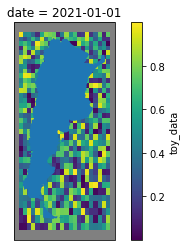

In [12]:
# (Optional) Check that we grabbed the correct region of data
data_day1 = bounded_toy_data[0]
p = data_day1.plot(
    subplot_kws=dict(projection=ccrs.Mercator(), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.add_geometries(geom, crs=ccrs.PlateCarree(),)

In [13]:
# 4. Mask data with geometry
width = len(bounded_toy_data.longitude)
height = len(bounded_toy_data.latitude)
mask = rasterio.features.geometry_mask(
    geom, 
    out_shape=(height, width),
    transform=rasterio.transform.from_bounds(
        bounded_toy_data.longitude[0],
        bounded_toy_data.latitude[-1],
        bounded_toy_data.longitude[-1],
        bounded_toy_data.latitude[0],
        width,
        height,
    ),
    invert=True
)
mask_data_array = xr.DataArray(
    mask,
    dims=("latitude", "longitude"), 
    coords=[bounded_toy_data.latitude, bounded_toy_data.longitude]
)
masked_toy_data = toy_data.where(mask_data_array)

# 5. Average data over time
avg_data = masked_toy_data.mean(dim="date")
avg_data

<xarray.DataArray 'toy_data' (latitude: 36, longitude: 22)>
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.47097372, 0.50395005,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
...
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.62286813, 0.60682333, 0.43899273, 0.43834695,
        0.5239618 , 0.56895159, 0.44045429, 0.40804996, 0.45288901,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.43097137, 0.54697051, 0.33146579,
        0.50993747, 0.38401969, 0.57657187,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.47821539, 0.58165048, 0.52995006,
        0.48581729, 0.55452418,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan]])
Coordinates:
  * latitude   (latitude) float64 -56.0 -55.0 -54.0 -53.0 ... -23.0 -22.0 -21.0
  * longitude  (longitude) float64 -74.0 -73.0 -72.0 -71.0 ... -55.0 -54.0 -53.0

/home/julia/.pyenv/versions/3.9.1/envs/vscode-3.9.1/lib/python3.9/site-packages/xarray/plot/utils.py:444: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(**kwargs)


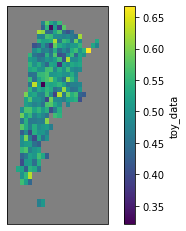

In [14]:
# 6. Plot the results
plot = avg_data.plot(
    subplot_kws=dict(projection=ccrs.Mercator(), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)

In [15]:
# Plot the median value of toy data in Brazil
